Suppose

* $K(x,x') = \exp(-\frac{\|x-x'\|^2}{2\ell^2})$ with $\ell=0.5$ (RBF with lengthscale 0.5)
* Independent noises
    * $\epsilon_1\sim N(0, \sigma^2 = 0.09)$
    * $\epsilon_2 \sim N(0, \sigma^2 = 0.01)$
* $f$ is mean zero GP with kernel $K$
* $y_1 = 2 f(x) + \epsilon_1$
* $y_2 = -0.5 f(x) + \epsilon_2$

Generate 100 observations of $(x, y_1, y_2)$ according to $x \in\{ 0.01, 0.02, 0.03, \cdots 1\}$ using ``sklearn``, then try to recover parameters with ``gpytorch``

In [1]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

import numpy as np
import matplotlib.pyplot as plt

import math
import torch
import gpytorch


In [2]:
l = 0.5
sigma1 = 0.3
sigma2 = 0.1
n = 100

X = np.linspace(0.01, 1, 100).reshape(-1,1)

K = RBF(length_scale=l)

f = GaussianProcessRegressor(kernel=K)
f_obs = f.sample_y(X, n_samples=1, random_state=1234)
f_obs = f_obs[:,0]

# generate noise

np.random.seed(12345)

y1 = 2 * f_obs + np.random.normal(scale=sigma1, size=100)
y2 = -0.5 * f_obs + np.random.normal(scale=sigma2, size=100)


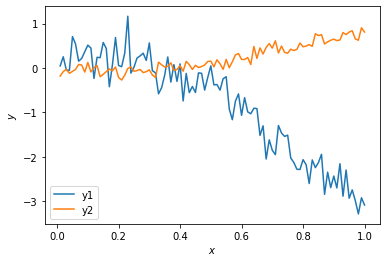

In [3]:
plt.plot(X, y1, label="y1")
plt.plot(X, y2, label="y2")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [23]:
train_x = torch.from_numpy(X).float()
train_y = torch.stack([
    torch.from_numpy(y1).float(),
    torch.from_numpy(y2).float(),
], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [24]:
training_iterations = 200

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/200 - Loss: 1.175
Iter 2/200 - Loss: 1.136
Iter 3/200 - Loss: 1.097
Iter 4/200 - Loss: 1.059
Iter 5/200 - Loss: 1.021
Iter 6/200 - Loss: 0.983
Iter 7/200 - Loss: 0.946
Iter 8/200 - Loss: 0.909
Iter 9/200 - Loss: 0.870
Iter 10/200 - Loss: 0.832
Iter 11/200 - Loss: 0.792
Iter 12/200 - Loss: 0.752
Iter 13/200 - Loss: 0.712
Iter 14/200 - Loss: 0.672
Iter 15/200 - Loss: 0.632
Iter 16/200 - Loss: 0.592
Iter 17/200 - Loss: 0.552
Iter 18/200 - Loss: 0.513
Iter 19/200 - Loss: 0.474
Iter 20/200 - Loss: 0.436
Iter 21/200 - Loss: 0.399
Iter 22/200 - Loss: 0.362
Iter 23/200 - Loss: 0.326
Iter 24/200 - Loss: 0.291
Iter 25/200 - Loss: 0.257
Iter 26/200 - Loss: 0.224
Iter 27/200 - Loss: 0.193
Iter 28/200 - Loss: 0.164
Iter 29/200 - Loss: 0.136
Iter 30/200 - Loss: 0.110
Iter 31/200 - Loss: 0.087
Iter 32/200 - Loss: 0.065
Iter 33/200 - Loss: 0.044
Iter 34/200 - Loss: 0.026
Iter 35/200 - Loss: 0.009
Iter 36/200 - Loss: -0.006
Iter 37/200 - Loss: -0.020
Iter 38/200 - Loss: -0.034
Iter 39/200 - Loss

``model.state_dict()`` returns many nonsensical values since they're on a transformed scale (not quite log):

In [25]:
model.state_dict()

OrderedDict([('likelihood.raw_task_noises', tensor([-2.4227, -5.8193])),
             ('likelihood.raw_noise', tensor([-5.0665])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('likelihood.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_noise_constraint.upper_bound', tensor(inf)),
             ('covar_module.task_covar_module.covar_factor',
              tensor([[-2.0625],
                      [ 0.5301]])),
             ('covar_module.task_covar_module.raw_var',
              tensor([ -7.9068, -10.3894])),
             ('covar_module.task_covar_module.raw_var_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.task_covar_module.raw_var_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.data_covar_module.raw_lengths

# Positive Parameters

Any parameters that were strictly positive can be transformed to interpretable values by defining a transformer according to the transform (*you could also define a similar transformer if there are other parameter constraints through those parameters*)

In [37]:
trans_to_pos = model.covar_module.task_covar_module.raw_var_constraint.transform

Now, use this as a function to transform any positive only quantity to the original hyperparameter, for example

In [38]:
raw_lengthscale = model.covar_module.data_covar_module.raw_lengthscale
lengthscale = trans_to_pos(raw_lengthscale)

print(f"raw lengthscale: {raw_lengthscale}")
print(f"lengthscale: {lengthscale}")

raw lengthscale: Parameter containing:
tensor([[-0.2058]], requires_grad=True)
lengthscale: tensor([[0.5956]], grad_fn=<SoftplusBackward0>)


The lengthscale of 0.5 is approximately recovered through model training.

# Other positive parameters

Here is one way to iterate through **all** parameters.

**Warning: this code will transform all parameters, whether positive or not.  Some should not be transformed, like ``covar_factor`` (discussed below)**

In [40]:
for param_name, param in model.named_parameters():
    print('Parameter name:')
    print(param_name)
    print(trans_to_pos(param))


Parameter name:
likelihood.raw_task_noises
tensor([0.0850, 0.0030], grad_fn=<SoftplusBackward0>)
Parameter name:
likelihood.raw_noise
tensor([0.0063], grad_fn=<SoftplusBackward0>)
Parameter name:
covar_module.task_covar_module.covar_factor
tensor([[0.1197],
        [0.9929]], grad_fn=<SoftplusBackward0>)
Parameter name:
covar_module.task_covar_module.raw_var
tensor([3.6815e-04, 3.0757e-05], grad_fn=<SoftplusBackward0>)
Parameter name:
covar_module.data_covar_module.raw_lengthscale
tensor([[0.5956]], grad_fn=<SoftplusBackward0>)


# Noises

**Recall:**

* Independent noises
    * $\epsilon_1\sim N(0, \sigma^2 = 0.09)$
    * $\epsilon_2 \sim N(0, \sigma^2 = 0.01)$
* $f$ is mean zero GP with kernel $K$
* $y_1 = 2 f(x) + \epsilon_1$
* $y_2 = -0.5 f(x) + \epsilon_2$

Still trying to figure out how to recover $\sigma_1^2$ and $\sigma_2^2$.  I think the ``gpytorch`` setup is moreso like

* $y_1 = 2 f(x) + \epsilon + \epsilon_1$
* $y_2 = -0.5 f(x) + \epsilon + \epsilon_2$

which is useful when you may expect correlated noises.

I believe in this case, we can get (slight abuse of notation since these are estimated values)

* $\text{var}(\epsilon) = 0.0063$:

In [41]:
trans_to_pos(model.likelihood.raw_noise)

tensor([0.0063], grad_fn=<SoftplusBackward0>)

* $\text{var}(\epsilon_1) = 0.0850$:
* $\text{var}(\epsilon_2) = 0.0030$:

In [42]:
trans_to_pos(model.likelihood.raw_task_noises)

tensor([0.0850, 0.0030], grad_fn=<SoftplusBackward0>)

Since epsilons are independent, the original epsilon variances would be

* $\sigma_1^2 = 0.09 \approx 0.0063 + 0.0850$
* $\sigma_2^2 = 0.01 \approx 0.0063 + 0.0030$

so this seems reasonable.

I'm not sure what this is.

In [45]:
raw_var = model.covar_module.task_covar_module.raw_var
trans_to_pos(raw_var)

tensor([3.6815e-04, 3.0757e-05], grad_fn=<SoftplusBackward0>)

# Linear Factors for Multioutput GP

Finally, remember

* $y_1 = 2 f(x) + \epsilon_1$
* $y_2 = -0.5 f(x) + \epsilon_2$

The coefficients $(2, -0.5)$ can be negative and should **not** be transformed.  Their untransformed values are available as such:

In [46]:
model.covar_module.task_covar_module.covar_factor

Parameter containing:
tensor([[-2.0625],
        [ 0.5301]], requires_grad=True)

It did a good job!

Note:

In [51]:
covar_factor = model.covar_module.task_covar_module.covar_factor

In [52]:
model.covar_module.task_covar_module.covar_matrix.evaluate()

tensor([[ 4.2544, -1.0934],
        [-1.0934,  0.2810]], grad_fn=<AddBackward0>)

In [54]:
torch.outer(covar_factor[:,0], covar_factor[:,0])

tensor([[ 4.2541, -1.0934],
        [-1.0934,  0.2810]], grad_fn=<MulBackward0>)

So, ``covar_matrix`` is the estimated matrix $B B^\top$ if

* $B = [2, -0.5]^\top$ (*actually not, see below*)

Note:

* It's possible that it's actually $B B^\top + \text{diag}(\sigma^2)$, where $\sigma^2$ is ``raw_var``??

(*this is true, I just investigated it.  See:*)

In [60]:
raw_var = model.covar_module.task_covar_module.raw_var
var = trans_to_pos(raw_var)




print(torch.outer(covar_factor[:,0], covar_factor[:,0]))
print(torch.outer(covar_factor[:,0], covar_factor[:,0]) + torch.diag(var))
print(model.covar_module.task_covar_module.covar_matrix.evaluate())

torch.set_printoptions(precision=4)




tensor([[ 4.2540683746, -1.0933755636],
        [-1.0933755636,  0.2810180783]], grad_fn=<MulBackward0>)
tensor([[ 4.2544364929, -1.0933755636],
        [-1.0933755636,  0.2810488343]], grad_fn=<AddBackward0>)
tensor([[ 4.2544364929, -1.0933755636],
        [-1.0933755636,  0.2810488343]], grad_fn=<AddBackward0>)


# Try plots...


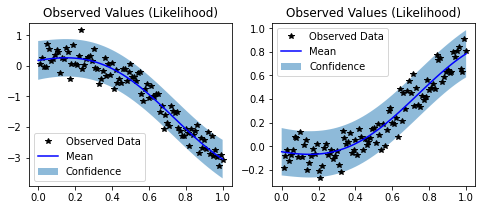

In [32]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()


# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
#y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
#y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None